In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
import tensorflow as tf
import keras.backend as K
from keras.applications import Xception
from keras.layers import UpSampling2D, Conv2D, Activation, LeakyReLU, BatchNormalization
from keras import Model
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tqdm import tqdm_notebook

Using TensorFlow backend.


### The Data

In [2]:
df_train = pd.read_csv('./input/severstal-steel-defect-detection/train.csv')

In [3]:
df_train.shape

(50272, 2)

In [4]:
df_train.head()

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [5]:
df_train['Defect'] = df_train['EncodedPixels'].notnull()
df_train['ClassId'] = df_train['ImageId_ClassId'].str[-1:]
df_train['ImageId'] = df_train['ImageId_ClassId'].str[:-2]

In [6]:
df_train.shape

(50272, 5)

In [7]:
df_train.head()

,ImageId_ClassId,EncodedPixels,Defect,ClassId,ImageId
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,True,1,0002cc93b.jpg
1,0002cc93b.jpg_2,NaN,False,2,0002cc93b.jpg
2,0002cc93b.jpg_3,NaN,False,3,0002cc93b.jpg
3,0002cc93b.jpg_4,NaN,False,4,0002cc93b.jpg
4,00031f466.jpg_1,NaN,False,1,00031f466.jpg


In [8]:
df_train = df_train[['ImageId','ClassId','Defect','EncodedPixels']]

In [9]:
df_train.shape

(50272, 4)

In [10]:
df_train.head()

,ImageId,ClassId,Defect,EncodedPixels
0,0002cc93b.jpg,1,True,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg,2,False,NaN
2,0002cc93b.jpg,3,False,NaN
3,0002cc93b.jpg,4,False,NaN
4,00031f466.jpg,1,False,NaN


In [11]:
df_train = df_train[df_train.Defect]

In [12]:
df_train.shape

(7095, 4)

In [13]:
df_train.head()

,ImageId,ClassId,Defect,EncodedPixels
0,0002cc93b.jpg,1,True,29102 12 29346 24 29602 24 29858 24 30114 24 3...
18,0007a71bf.jpg,3,True,18661 28 18863 82 19091 110 19347 110 19603 11...
20,000a4bcdd.jpg,1,True,37607 3 37858 8 38108 14 38359 20 38610 25 388...
27,000f6bf48.jpg,4,True,131973 1 132228 4 132483 6 132738 8 132993 11 ...
30,0014fce06.jpg,3,True,229501 11 229741 33 229981 55 230221 77 230468...


In [14]:
df_train = df_train.drop(['Defect'], axis=1)

In [15]:
df_train.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
18,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
20,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
27,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
30,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


### Utility functions

In [16]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

In [17]:
img = [
    [0, 1, 0, 0, 0],
    [0, 1, 1, 1, 0], 
    [0, 1, 0, 1, 0],
    [0, 1, 1, 1, 0], 
    [0, 0, 0, 1, 0],
]

res = mask2rle(img)
print(res)

5 4 11 1 13 1 16 4


In [18]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

In [19]:
res = rle2mask("5 4 11 1 13 1 16 4", (5, 5))
print(res)

[[0 1 0 0 0]
 [0 1 1 1 0]
 [0 1 0 1 0]
 [0 1 1 1 0]
 [0 0 0 1 0]]


### Xception Model in Keras

In [20]:
ORIG_IMG_SIZE_HEIGHT = 256
ORIG_IMG_SIZE_WIDTH = 1600
TRAIN_IMG_SIZE_HEIGHT = 128
TRAIN_IMG_SIZE_WIDTH = 800

BATCH_SIZE = 2
EPOCHS = 3
PATIENCE = 2

In [21]:
def keras_generator(batch_size):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):            
            fn = df_train['ImageId'].iloc[i]
            img = cv2.imread( './input/severstal-steel-defect-detection/train_images/'+fn )
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)            
#            print('Before Image: '+ fn + '; shape: ' + str(img.shape))
            
            mask = rle2mask(df_train['EncodedPixels'].iloc[i], img.shape)
            
#            img = cv2.resize(img, (TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH))
#            mask = cv2.resize(mask, (TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH))
            img = cv2.resize(img, (TRAIN_IMG_SIZE_WIDTH, TRAIN_IMG_SIZE_HEIGHT))
            mask = cv2.resize(mask, (TRAIN_IMG_SIZE_WIDTH, TRAIN_IMG_SIZE_HEIGHT))
#            print('After Image: '+ fn + '; shape: ' + str(img.shape))
            
            x_batch += [img]
            y_batch += [mask]
                                    
        x_batch = np.array(x_batch)
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

In [22]:
def dice_coeff(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    loss = 0.5 * binary_crossentropy(y_true, y_pred) - 2*dice_coeff(y_true, y_pred)
    return loss


In [23]:
base_model = Xception(weights='imagenet', input_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH, 3), include_top=False) #include_top=False excludes final FC layer
base_model.summary()


Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 800, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 399, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 399, 32)  128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 399, 32)  0           block1_conv1_bn[0][0]            
_____________________________________

__________________________________________________________________________________________________
block5_sepconv1 (SeparableConv2 (None, 8, 50, 728)   536536      block5_sepconv1_act[0][0]        
__________________________________________________________________________________________________
block5_sepconv1_bn (BatchNormal (None, 8, 50, 728)   2912        block5_sepconv1[0][0]            
__________________________________________________________________________________________________
block5_sepconv2_act (Activation (None, 8, 50, 728)   0           block5_sepconv1_bn[0][0]         
__________________________________________________________________________________________________
block5_sepconv2 (SeparableConv2 (None, 8, 50, 728)   536536      block5_sepconv2_act[0][0]        
__________________________________________________________________________________________________
block5_sepconv2_bn (BatchNormal (None, 8, 50, 728)   2912        block5_sepconv2[0][0]            
__________

__________________________________________________________________________________________________
block9_sepconv1_act (Activation (None, 8, 50, 728)   0           add_7[0][0]                      
__________________________________________________________________________________________________
block9_sepconv1 (SeparableConv2 (None, 8, 50, 728)   536536      block9_sepconv1_act[0][0]        
__________________________________________________________________________________________________
block9_sepconv1_bn (BatchNormal (None, 8, 50, 728)   2912        block9_sepconv1[0][0]            
__________________________________________________________________________________________________
block9_sepconv2_act (Activation (None, 8, 50, 728)   0           block9_sepconv1_bn[0][0]         
__________________________________________________________________________________________________
block9_sepconv2 (SeparableConv2 (None, 8, 50, 728)   536536      block9_sepconv2_act[0][0]        
__________

add_11 (Add)                    (None, 8, 50, 728)   0           block12_sepconv3_bn[0][0]        
                                                                 add_10[0][0]                     
__________________________________________________________________________________________________
block13_sepconv1_act (Activatio (None, 8, 50, 728)   0           add_11[0][0]                     
__________________________________________________________________________________________________
block13_sepconv1 (SeparableConv (None, 8, 50, 728)   536536      block13_sepconv1_act[0][0]       
__________________________________________________________________________________________________
block13_sepconv1_bn (BatchNorma (None, 8, 50, 728)   2912        block13_sepconv1[0][0]           
__________________________________________________________________________________________________
block13_sepconv2_act (Activatio (None, 8, 50, 728)   0           block13_sepconv1_bn[0][0]        
__________

In [24]:
base_out = base_model.output
up1 = UpSampling2D(32, interpolation='bilinear')(base_out)
conv1 = Conv2D(1, (1, 1))(up1)
conv1 = Activation('sigmoid')(conv1)

model = Model(base_model.input, conv1)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 800, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 399, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 399, 32)  128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 399, 32)  0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

block5_sepconv1_bn (BatchNormal (None, 8, 50, 728)   2912        block5_sepconv1[0][0]            
__________________________________________________________________________________________________
block5_sepconv2_act (Activation (None, 8, 50, 728)   0           block5_sepconv1_bn[0][0]         
__________________________________________________________________________________________________
block5_sepconv2 (SeparableConv2 (None, 8, 50, 728)   536536      block5_sepconv2_act[0][0]        
__________________________________________________________________________________________________
block5_sepconv2_bn (BatchNormal (None, 8, 50, 728)   2912        block5_sepconv2[0][0]            
__________________________________________________________________________________________________
block5_sepconv3_act (Activation (None, 8, 50, 728)   0           block5_sepconv2_bn[0][0]         
__________________________________________________________________________________________________
block5_sep

block9_sepconv1 (SeparableConv2 (None, 8, 50, 728)   536536      block9_sepconv1_act[0][0]        
__________________________________________________________________________________________________
block9_sepconv1_bn (BatchNormal (None, 8, 50, 728)   2912        block9_sepconv1[0][0]            
__________________________________________________________________________________________________
block9_sepconv2_act (Activation (None, 8, 50, 728)   0           block9_sepconv1_bn[0][0]         
__________________________________________________________________________________________________
block9_sepconv2 (SeparableConv2 (None, 8, 50, 728)   536536      block9_sepconv2_act[0][0]        
__________________________________________________________________________________________________
block9_sepconv2_bn (BatchNormal (None, 8, 50, 728)   2912        block9_sepconv2[0][0]            
__________________________________________________________________________________________________
block9_sep

block13_sepconv1_act (Activatio (None, 8, 50, 728)   0           add_11[0][0]                     
__________________________________________________________________________________________________
block13_sepconv1 (SeparableConv (None, 8, 50, 728)   536536      block13_sepconv1_act[0][0]       
__________________________________________________________________________________________________
block13_sepconv1_bn (BatchNorma (None, 8, 50, 728)   2912        block13_sepconv1[0][0]           
__________________________________________________________________________________________________
block13_sepconv2_act (Activatio (None, 8, 50, 728)   0           block13_sepconv1_bn[0][0]        
__________________________________________________________________________________________________
block13_sepconv2 (SeparableConv (None, 8, 50, 1024)  752024      block13_sepconv2_act[0][0]       
__________________________________________________________________________________________________
block13_se

In [25]:
from keras.optimizers import RMSprop

#model.compile(loss=bce_dice_loss, optimizer='adam', metrics=[iou_metric])
model.compile(optimizer=RMSprop(lr=0.00075), loss=bce_dice_loss, metrics=['accuracy', dice_coeff])

In [26]:
# A decreasing learning rate schedule (continuous decrease)
def continuous_decay(epoch):
    initial_lrate = 0.01
    lr = initial_lrate * (0.1 ** int(epoch / 10))
    return lr

# Another decreasing learning rate schedule (stepped decrease)
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 5.0
    lr = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

def get_callback(patient):
    ES = EarlyStopping(
        monitor='loss', 
        patience=patient, 
        mode='max', 
        verbose=1)
    RR = ReduceLROnPlateau(
        monitor = 'loss', 
        factor = 0.5, 
        patience = patient / 2, 
        min_lr=0.000001, 
        verbose=1, 
        mode='max')
    LR = LearningRateScheduler(
        continuous_decay,
        verbose=1)
    MC = ModelCheckpoint(
        filepath='./Xcep_model_CD_LR0_01.h5', 
        save_best_only=True,
        verbose=1)
#    return [ES, RR, LR, MC]
    return [ES, LR, MC]


In [27]:
history = model.fit_generator(keras_generator(BATCH_SIZE),
                              steps_per_epoch=len(df_train.index)/EPOCHS,                    
                              epochs=EPOCHS,                    
                              verbose=1,
                              shuffle=True,
                              callbacks = get_callback(PATIENCE)
                             )

Instructions for updating:
Use tf.cast instead.
Epoch 1/3

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.


 132/2365 [>.............................] - ETA: 8:15:30 - loss: 0.2753 - acc: 0.5837 - dice_coeff: 0.032 - ETA: 4:14:26 - loss: 0.2681 - acc: 0.7845 - dice_coeff: 0.024 - ETA: 2:54:01 - loss: 0.2422 - acc: 0.8514 - dice_coeff: 0.022 - ETA: 2:13:48 - loss: 0.2065 - acc: 0.8849 - dice_coeff: 0.026 - ETA: 1:49:42 - loss: 0.1851 - acc: 0.9035 - dice_coeff: 0.025 - ETA: 1:33:35 - loss: 0.1674 - acc: 0.9171 - dice_coeff: 0.022 - ETA: 1:22:06 - loss: 0.1669 - acc: 0.9268 - dice_coeff: 0.022 - ETA: 1:13:28 - loss: 0.1556 - acc: 0.9341 - dice_coeff: 0.020 - ETA: 1:06:47 - loss: 0.1244 - acc: 0.9398 - dice_coeff: 0.028 - ETA: 1:01:24 - loss: 0.1202 - acc: 0.9444 - dice_coeff: 0.025 - ETA: 57:00 - loss: 0.1081 - acc: 0.9481 - dice_coeff: 0.0275  - ETA: 53:21 - loss: 0.1088 - acc: 0.9512 - dice_coeff: 0.025 - ETA: 50:14 - loss: 0.1054 - acc: 0.9538 - dice_coeff: 0.025 - ETA: 47:35 - loss: 0.0946 - acc: 0.9560 - dice_coeff: 0.026 - ETA: 45:17 - loss: 0.0930 - acc: 0.9580 - dice_coeff: 0.025 - ETA

 264/2365 [==>...........................] - ETA: 16:07 - loss: -0.7120 - acc: 0.9809 - dice_coeff: 0.38 - ETA: 16:05 - loss: -0.7174 - acc: 0.9810 - dice_coeff: 0.39 - ETA: 16:03 - loss: -0.7227 - acc: 0.9810 - dice_coeff: 0.39 - ETA: 16:01 - loss: -0.7166 - acc: 0.9811 - dice_coeff: 0.39 - ETA: 15:59 - loss: -0.7111 - acc: 0.9811 - dice_coeff: 0.38 - ETA: 15:57 - loss: -0.7156 - acc: 0.9812 - dice_coeff: 0.39 - ETA: 15:55 - loss: -0.7201 - acc: 0.9813 - dice_coeff: 0.39 - ETA: 15:54 - loss: -0.7178 - acc: 0.9813 - dice_coeff: 0.39 - ETA: 15:52 - loss: -0.7212 - acc: 0.9813 - dice_coeff: 0.39 - ETA: 15:50 - loss: -0.7261 - acc: 0.9814 - dice_coeff: 0.39 - ETA: 15:48 - loss: -0.7302 - acc: 0.9815 - dice_coeff: 0.39 - ETA: 15:46 - loss: -0.7333 - acc: 0.9815 - dice_coeff: 0.39 - ETA: 15:45 - loss: -0.7376 - acc: 0.9816 - dice_coeff: 0.40 - ETA: 15:43 - loss: -0.7409 - acc: 0.9817 - dice_coeff: 0.40 - ETA: 15:41 - loss: -0.7441 - acc: 0.9817 - dice_coeff: 0.40 - ETA: 15:40 - loss: -0.748

 396/2365 [====>.........................] - ETA: 13:34 - loss: -1.0805 - acc: 0.9868 - dice_coeff: 0.56 - ETA: 13:33 - loss: -1.0822 - acc: 0.9868 - dice_coeff: 0.56 - ETA: 13:32 - loss: -1.0839 - acc: 0.9868 - dice_coeff: 0.56 - ETA: 13:31 - loss: -1.0853 - acc: 0.9868 - dice_coeff: 0.56 - ETA: 13:31 - loss: -1.0870 - acc: 0.9869 - dice_coeff: 0.56 - ETA: 13:30 - loss: -1.0886 - acc: 0.9869 - dice_coeff: 0.56 - ETA: 13:29 - loss: -1.0902 - acc: 0.9869 - dice_coeff: 0.56 - ETA: 13:29 - loss: -1.0919 - acc: 0.9869 - dice_coeff: 0.57 - ETA: 13:28 - loss: -1.0935 - acc: 0.9870 - dice_coeff: 0.57 - ETA: 13:27 - loss: -1.0953 - acc: 0.9870 - dice_coeff: 0.57 - ETA: 13:26 - loss: -1.0969 - acc: 0.9870 - dice_coeff: 0.57 - ETA: 13:26 - loss: -1.0987 - acc: 0.9870 - dice_coeff: 0.57 - ETA: 13:25 - loss: -1.1005 - acc: 0.9871 - dice_coeff: 0.57 - ETA: 13:24 - loss: -1.1022 - acc: 0.9871 - dice_coeff: 0.57 - ETA: 13:24 - loss: -1.1038 - acc: 0.9871 - dice_coeff: 0.57 - ETA: 13:23 - loss: -1.105

 528/2365 [=====>........................] - ETA: 12:12 - loss: -1.2361 - acc: 0.9891 - dice_coeff: 0.63 - ETA: 12:12 - loss: -1.2370 - acc: 0.9891 - dice_coeff: 0.64 - ETA: 12:11 - loss: -1.2378 - acc: 0.9891 - dice_coeff: 0.64 - ETA: 12:11 - loss: -1.2387 - acc: 0.9891 - dice_coeff: 0.64 - ETA: 12:10 - loss: -1.2394 - acc: 0.9891 - dice_coeff: 0.64 - ETA: 12:10 - loss: -1.2402 - acc: 0.9891 - dice_coeff: 0.64 - ETA: 12:09 - loss: -1.2411 - acc: 0.9891 - dice_coeff: 0.64 - ETA: 12:09 - loss: -1.2419 - acc: 0.9892 - dice_coeff: 0.64 - ETA: 12:08 - loss: -1.2428 - acc: 0.9892 - dice_coeff: 0.64 - ETA: 12:08 - loss: -1.2437 - acc: 0.9892 - dice_coeff: 0.64 - ETA: 12:07 - loss: -1.2445 - acc: 0.9892 - dice_coeff: 0.64 - ETA: 12:07 - loss: -1.2453 - acc: 0.9892 - dice_coeff: 0.64 - ETA: 12:06 - loss: -1.2460 - acc: 0.9892 - dice_coeff: 0.64 - ETA: 12:06 - loss: -1.2467 - acc: 0.9892 - dice_coeff: 0.64 - ETA: 12:05 - loss: -1.2475 - acc: 0.9892 - dice_coeff: 0.64 - ETA: 12:05 - loss: -1.248

 660/2365 [=======>......................] - ETA: 11:09 - loss: -1.3197 - acc: 0.9903 - dice_coeff: 0.67 - ETA: 11:09 - loss: -1.3201 - acc: 0.9903 - dice_coeff: 0.68 - ETA: 11:08 - loss: -1.3206 - acc: 0.9903 - dice_coeff: 0.68 - ETA: 11:08 - loss: -1.3211 - acc: 0.9903 - dice_coeff: 0.68 - ETA: 11:07 - loss: -1.3216 - acc: 0.9903 - dice_coeff: 0.68 - ETA: 11:07 - loss: -1.3220 - acc: 0.9903 - dice_coeff: 0.68 - ETA: 11:06 - loss: -1.3224 - acc: 0.9903 - dice_coeff: 0.68 - ETA: 11:06 - loss: -1.3228 - acc: 0.9904 - dice_coeff: 0.68 - ETA: 11:05 - loss: -1.3233 - acc: 0.9904 - dice_coeff: 0.68 - ETA: 11:05 - loss: -1.3238 - acc: 0.9904 - dice_coeff: 0.68 - ETA: 11:05 - loss: -1.3242 - acc: 0.9904 - dice_coeff: 0.68 - ETA: 11:04 - loss: -1.3248 - acc: 0.9904 - dice_coeff: 0.68 - ETA: 11:04 - loss: -1.3252 - acc: 0.9904 - dice_coeff: 0.68 - ETA: 11:03 - loss: -1.3257 - acc: 0.9904 - dice_coeff: 0.68 - ETA: 11:03 - loss: -1.3261 - acc: 0.9904 - dice_coeff: 0.68 - ETA: 11:02 - loss: -1.326

 792/2365 [=========>....................] - ETA: 10:13 - loss: -1.3721 - acc: 0.9911 - dice_coeff: 0.70 - ETA: 10:13 - loss: -1.3724 - acc: 0.9911 - dice_coeff: 0.70 - ETA: 10:12 - loss: -1.3728 - acc: 0.9911 - dice_coeff: 0.70 - ETA: 10:12 - loss: -1.3731 - acc: 0.9911 - dice_coeff: 0.70 - ETA: 10:11 - loss: -1.3734 - acc: 0.9911 - dice_coeff: 0.70 - ETA: 10:11 - loss: -1.3733 - acc: 0.9911 - dice_coeff: 0.70 - ETA: 10:11 - loss: -1.3736 - acc: 0.9911 - dice_coeff: 0.70 - ETA: 10:10 - loss: -1.3736 - acc: 0.9911 - dice_coeff: 0.70 - ETA: 10:10 - loss: -1.3738 - acc: 0.9911 - dice_coeff: 0.70 - ETA: 10:09 - loss: -1.3741 - acc: 0.9911 - dice_coeff: 0.70 - ETA: 10:09 - loss: -1.3743 - acc: 0.9911 - dice_coeff: 0.70 - ETA: 10:09 - loss: -1.3746 - acc: 0.9911 - dice_coeff: 0.70 - ETA: 10:08 - loss: -1.3749 - acc: 0.9911 - dice_coeff: 0.70 - ETA: 10:08 - loss: -1.3751 - acc: 0.9911 - dice_coeff: 0.70 - ETA: 10:07 - loss: -1.3754 - acc: 0.9911 - dice_coeff: 0.70 - ETA: 10:07 - loss: -1.375

 924/2365 [==========>...................] - ETA: 9:21 - loss: -1.4078 - acc: 0.9916 - dice_coeff: 0.722 - ETA: 9:20 - loss: -1.4080 - acc: 0.9916 - dice_coeff: 0.722 - ETA: 9:20 - loss: -1.4083 - acc: 0.9916 - dice_coeff: 0.722 - ETA: 9:20 - loss: -1.4085 - acc: 0.9916 - dice_coeff: 0.722 - ETA: 9:19 - loss: -1.4087 - acc: 0.9916 - dice_coeff: 0.723 - ETA: 9:19 - loss: -1.4089 - acc: 0.9916 - dice_coeff: 0.723 - ETA: 9:18 - loss: -1.4091 - acc: 0.9916 - dice_coeff: 0.723 - ETA: 9:18 - loss: -1.4093 - acc: 0.9916 - dice_coeff: 0.723 - ETA: 9:18 - loss: -1.4096 - acc: 0.9917 - dice_coeff: 0.723 - ETA: 9:17 - loss: -1.4098 - acc: 0.9917 - dice_coeff: 0.723 - ETA: 9:17 - loss: -1.4100 - acc: 0.9917 - dice_coeff: 0.723 - ETA: 9:16 - loss: -1.4103 - acc: 0.9917 - dice_coeff: 0.723 - ETA: 9:16 - loss: -1.4105 - acc: 0.9917 - dice_coeff: 0.723 - ETA: 9:16 - loss: -1.4106 - acc: 0.9917 - dice_coeff: 0.724 - ETA: 9:15 - loss: -1.4108 - acc: 0.9917 - dice_coeff: 0.724 - ETA: 9:15 - loss: -1.4110

1056/2365 [============>.................] - ETA: 8:30 - loss: -1.4346 - acc: 0.9920 - dice_coeff: 0.735 - ETA: 8:30 - loss: -1.4348 - acc: 0.9920 - dice_coeff: 0.735 - ETA: 8:30 - loss: -1.4350 - acc: 0.9920 - dice_coeff: 0.735 - ETA: 8:29 - loss: -1.4352 - acc: 0.9920 - dice_coeff: 0.735 - ETA: 8:29 - loss: -1.4354 - acc: 0.9920 - dice_coeff: 0.736 - ETA: 8:28 - loss: -1.4356 - acc: 0.9920 - dice_coeff: 0.736 - ETA: 8:28 - loss: -1.4358 - acc: 0.9920 - dice_coeff: 0.736 - ETA: 8:28 - loss: -1.4359 - acc: 0.9920 - dice_coeff: 0.736 - ETA: 8:27 - loss: -1.4360 - acc: 0.9920 - dice_coeff: 0.736 - ETA: 8:27 - loss: -1.4362 - acc: 0.9920 - dice_coeff: 0.736 - ETA: 8:27 - loss: -1.4364 - acc: 0.9920 - dice_coeff: 0.736 - ETA: 8:26 - loss: -1.4364 - acc: 0.9921 - dice_coeff: 0.736 - ETA: 8:26 - loss: -1.4366 - acc: 0.9921 - dice_coeff: 0.736 - ETA: 8:25 - loss: -1.4366 - acc: 0.9921 - dice_coeff: 0.736 - ETA: 8:25 - loss: -1.4367 - acc: 0.9921 - dice_coeff: 0.736 - ETA: 8:25 - loss: -1.4369

1188/2365 [==============>...............] - ETA: 7:41 - loss: -1.4552 - acc: 0.9923 - dice_coeff: 0.745 - ETA: 7:41 - loss: -1.4553 - acc: 0.9923 - dice_coeff: 0.745 - ETA: 7:41 - loss: -1.4555 - acc: 0.9923 - dice_coeff: 0.745 - ETA: 7:40 - loss: -1.4555 - acc: 0.9923 - dice_coeff: 0.745 - ETA: 7:40 - loss: -1.4557 - acc: 0.9923 - dice_coeff: 0.745 - ETA: 7:40 - loss: -1.4558 - acc: 0.9923 - dice_coeff: 0.745 - ETA: 7:39 - loss: -1.4559 - acc: 0.9923 - dice_coeff: 0.746 - ETA: 7:39 - loss: -1.4561 - acc: 0.9923 - dice_coeff: 0.746 - ETA: 7:39 - loss: -1.4562 - acc: 0.9923 - dice_coeff: 0.746 - ETA: 7:38 - loss: -1.4564 - acc: 0.9923 - dice_coeff: 0.746 - ETA: 7:38 - loss: -1.4565 - acc: 0.9923 - dice_coeff: 0.746 - ETA: 7:37 - loss: -1.4567 - acc: 0.9923 - dice_coeff: 0.746 - ETA: 7:37 - loss: -1.4568 - acc: 0.9924 - dice_coeff: 0.746 - ETA: 7:37 - loss: -1.4570 - acc: 0.9924 - dice_coeff: 0.746 - ETA: 7:36 - loss: -1.4571 - acc: 0.9924 - dice_coeff: 0.746 - ETA: 7:36 - loss: -1.4573

1320/2365 [===============>..............] - ETA: 6:53 - loss: -1.4714 - acc: 0.9926 - dice_coeff: 0.753 - ETA: 6:53 - loss: -1.4716 - acc: 0.9926 - dice_coeff: 0.753 - ETA: 6:53 - loss: -1.4717 - acc: 0.9926 - dice_coeff: 0.753 - ETA: 6:52 - loss: -1.4718 - acc: 0.9926 - dice_coeff: 0.753 - ETA: 6:52 - loss: -1.4719 - acc: 0.9926 - dice_coeff: 0.753 - ETA: 6:52 - loss: -1.4721 - acc: 0.9926 - dice_coeff: 0.753 - ETA: 6:51 - loss: -1.4722 - acc: 0.9926 - dice_coeff: 0.753 - ETA: 6:51 - loss: -1.4723 - acc: 0.9926 - dice_coeff: 0.754 - ETA: 6:51 - loss: -1.4724 - acc: 0.9926 - dice_coeff: 0.754 - ETA: 6:50 - loss: -1.4725 - acc: 0.9926 - dice_coeff: 0.754 - ETA: 6:50 - loss: -1.4726 - acc: 0.9926 - dice_coeff: 0.754 - ETA: 6:49 - loss: -1.4727 - acc: 0.9926 - dice_coeff: 0.754 - ETA: 6:49 - loss: -1.4728 - acc: 0.9926 - dice_coeff: 0.754 - ETA: 6:49 - loss: -1.4730 - acc: 0.9926 - dice_coeff: 0.754 - ETA: 6:48 - loss: -1.4731 - acc: 0.9926 - dice_coeff: 0.754 - ETA: 6:48 - loss: -1.4732

1452/2365 [=================>............] - ETA: 6:06 - loss: -1.4846 - acc: 0.9928 - dice_coeff: 0.760 - ETA: 6:06 - loss: -1.4847 - acc: 0.9928 - dice_coeff: 0.760 - ETA: 6:05 - loss: -1.4848 - acc: 0.9928 - dice_coeff: 0.760 - ETA: 6:05 - loss: -1.4849 - acc: 0.9928 - dice_coeff: 0.760 - ETA: 6:05 - loss: -1.4850 - acc: 0.9928 - dice_coeff: 0.760 - ETA: 6:04 - loss: -1.4851 - acc: 0.9928 - dice_coeff: 0.760 - ETA: 6:04 - loss: -1.4852 - acc: 0.9928 - dice_coeff: 0.760 - ETA: 6:03 - loss: -1.4853 - acc: 0.9928 - dice_coeff: 0.760 - ETA: 6:03 - loss: -1.4854 - acc: 0.9928 - dice_coeff: 0.760 - ETA: 6:03 - loss: -1.4855 - acc: 0.9928 - dice_coeff: 0.760 - ETA: 6:02 - loss: -1.4856 - acc: 0.9928 - dice_coeff: 0.760 - ETA: 6:02 - loss: -1.4857 - acc: 0.9928 - dice_coeff: 0.760 - ETA: 6:02 - loss: -1.4857 - acc: 0.9928 - dice_coeff: 0.760 - ETA: 6:01 - loss: -1.4858 - acc: 0.9928 - dice_coeff: 0.760 - ETA: 6:01 - loss: -1.4859 - acc: 0.9928 - dice_coeff: 0.760 - ETA: 6:01 - loss: -1.4860

1584/2365 [===================>..........] - ETA: 5:19 - loss: -1.4956 - acc: 0.9929 - dice_coeff: 0.765 - ETA: 5:19 - loss: -1.4957 - acc: 0.9929 - dice_coeff: 0.765 - ETA: 5:18 - loss: -1.4958 - acc: 0.9929 - dice_coeff: 0.765 - ETA: 5:18 - loss: -1.4959 - acc: 0.9929 - dice_coeff: 0.765 - ETA: 5:18 - loss: -1.4960 - acc: 0.9929 - dice_coeff: 0.765 - ETA: 5:17 - loss: -1.4960 - acc: 0.9929 - dice_coeff: 0.765 - ETA: 5:17 - loss: -1.4961 - acc: 0.9929 - dice_coeff: 0.765 - ETA: 5:16 - loss: -1.4962 - acc: 0.9929 - dice_coeff: 0.765 - ETA: 5:16 - loss: -1.4963 - acc: 0.9929 - dice_coeff: 0.765 - ETA: 5:16 - loss: -1.4963 - acc: 0.9929 - dice_coeff: 0.765 - ETA: 5:15 - loss: -1.4964 - acc: 0.9929 - dice_coeff: 0.765 - ETA: 5:15 - loss: -1.4964 - acc: 0.9929 - dice_coeff: 0.765 - ETA: 5:15 - loss: -1.4965 - acc: 0.9929 - dice_coeff: 0.765 - ETA: 5:14 - loss: -1.4966 - acc: 0.9929 - dice_coeff: 0.766 - ETA: 5:14 - loss: -1.4967 - acc: 0.9929 - dice_coeff: 0.766 - ETA: 5:14 - loss: -1.4967

1716/2365 [====================>.........] - ETA: 4:32 - loss: -1.5003 - acc: 0.9930 - dice_coeff: 0.767 - ETA: 4:32 - loss: -1.5003 - acc: 0.9930 - dice_coeff: 0.768 - ETA: 4:32 - loss: -1.5003 - acc: 0.9930 - dice_coeff: 0.768 - ETA: 4:31 - loss: -1.5003 - acc: 0.9930 - dice_coeff: 0.768 - ETA: 4:31 - loss: -1.5004 - acc: 0.9930 - dice_coeff: 0.768 - ETA: 4:30 - loss: -1.5004 - acc: 0.9930 - dice_coeff: 0.768 - ETA: 4:30 - loss: -1.5004 - acc: 0.9930 - dice_coeff: 0.768 - ETA: 4:30 - loss: -1.5004 - acc: 0.9930 - dice_coeff: 0.768 - ETA: 4:29 - loss: -1.5004 - acc: 0.9930 - dice_coeff: 0.768 - ETA: 4:29 - loss: -1.5005 - acc: 0.9930 - dice_coeff: 0.768 - ETA: 4:29 - loss: -1.5005 - acc: 0.9930 - dice_coeff: 0.768 - ETA: 4:28 - loss: -1.5005 - acc: 0.9930 - dice_coeff: 0.768 - ETA: 4:28 - loss: -1.5005 - acc: 0.9930 - dice_coeff: 0.768 - ETA: 4:28 - loss: -1.5006 - acc: 0.9930 - dice_coeff: 0.768 - ETA: 4:27 - loss: -1.5006 - acc: 0.9930 - dice_coeff: 0.768 - ETA: 4:27 - loss: -1.5006

1848/2365 [======================>.......] - ETA: 3:46 - loss: -1.5027 - acc: 0.9931 - dice_coeff: 0.769 - ETA: 3:45 - loss: -1.5027 - acc: 0.9931 - dice_coeff: 0.769 - ETA: 3:45 - loss: -1.5027 - acc: 0.9931 - dice_coeff: 0.769 - ETA: 3:45 - loss: -1.5028 - acc: 0.9931 - dice_coeff: 0.769 - ETA: 3:44 - loss: -1.5028 - acc: 0.9931 - dice_coeff: 0.769 - ETA: 3:44 - loss: -1.5028 - acc: 0.9931 - dice_coeff: 0.769 - ETA: 3:44 - loss: -1.5028 - acc: 0.9931 - dice_coeff: 0.769 - ETA: 3:43 - loss: -1.5028 - acc: 0.9931 - dice_coeff: 0.769 - ETA: 3:43 - loss: -1.5029 - acc: 0.9931 - dice_coeff: 0.769 - ETA: 3:43 - loss: -1.5029 - acc: 0.9931 - dice_coeff: 0.769 - ETA: 3:42 - loss: -1.5029 - acc: 0.9931 - dice_coeff: 0.769 - ETA: 3:42 - loss: -1.5029 - acc: 0.9931 - dice_coeff: 0.769 - ETA: 3:42 - loss: -1.5029 - acc: 0.9931 - dice_coeff: 0.769 - ETA: 3:41 - loss: -1.5030 - acc: 0.9931 - dice_coeff: 0.769 - ETA: 3:41 - loss: -1.5030 - acc: 0.9931 - dice_coeff: 0.769 - ETA: 3:41 - loss: -1.5030

1980/2365 [========================>.....] - ETA: 3:00 - loss: -1.5050 - acc: 0.9932 - dice_coeff: 0.770 - ETA: 2:59 - loss: -1.5050 - acc: 0.9932 - dice_coeff: 0.770 - ETA: 2:59 - loss: -1.5050 - acc: 0.9932 - dice_coeff: 0.770 - ETA: 2:59 - loss: -1.5050 - acc: 0.9932 - dice_coeff: 0.770 - ETA: 2:58 - loss: -1.5050 - acc: 0.9932 - dice_coeff: 0.770 - ETA: 2:58 - loss: -1.5050 - acc: 0.9932 - dice_coeff: 0.770 - ETA: 2:57 - loss: -1.5050 - acc: 0.9932 - dice_coeff: 0.770 - ETA: 2:57 - loss: -1.5050 - acc: 0.9932 - dice_coeff: 0.770 - ETA: 2:57 - loss: -1.5051 - acc: 0.9932 - dice_coeff: 0.770 - ETA: 2:56 - loss: -1.5051 - acc: 0.9932 - dice_coeff: 0.770 - ETA: 2:56 - loss: -1.5051 - acc: 0.9932 - dice_coeff: 0.770 - ETA: 2:56 - loss: -1.5051 - acc: 0.9932 - dice_coeff: 0.770 - ETA: 2:55 - loss: -1.5051 - acc: 0.9932 - dice_coeff: 0.770 - ETA: 2:55 - loss: -1.5052 - acc: 0.9932 - dice_coeff: 0.770 - ETA: 2:55 - loss: -1.5052 - acc: 0.9932 - dice_coeff: 0.770 - ETA: 2:54 - loss: -1.5052

2112/2365 [=========================>....] - ETA: 2:13 - loss: -1.5069 - acc: 0.9933 - dice_coeff: 0.771 - ETA: 2:13 - loss: -1.5069 - acc: 0.9933 - dice_coeff: 0.771 - ETA: 2:13 - loss: -1.5070 - acc: 0.9933 - dice_coeff: 0.771 - ETA: 2:12 - loss: -1.5070 - acc: 0.9933 - dice_coeff: 0.771 - ETA: 2:12 - loss: -1.5070 - acc: 0.9933 - dice_coeff: 0.771 - ETA: 2:12 - loss: -1.5070 - acc: 0.9933 - dice_coeff: 0.771 - ETA: 2:11 - loss: -1.5070 - acc: 0.9933 - dice_coeff: 0.771 - ETA: 2:11 - loss: -1.5070 - acc: 0.9933 - dice_coeff: 0.771 - ETA: 2:11 - loss: -1.5071 - acc: 0.9933 - dice_coeff: 0.771 - ETA: 2:10 - loss: -1.5071 - acc: 0.9933 - dice_coeff: 0.771 - ETA: 2:10 - loss: -1.5070 - acc: 0.9933 - dice_coeff: 0.771 - ETA: 2:10 - loss: -1.5071 - acc: 0.9933 - dice_coeff: 0.771 - ETA: 2:09 - loss: -1.5071 - acc: 0.9933 - dice_coeff: 0.771 - ETA: 2:09 - loss: -1.5071 - acc: 0.9933 - dice_coeff: 0.771 - ETA: 2:08 - loss: -1.5071 - acc: 0.9933 - dice_coeff: 0.771 - ETA: 2:08 - loss: -1.5071

2246/2365 [===========================>..] - ETA: 1:27 - loss: -1.5088 - acc: 0.9933 - dice_coeff: 0.772 - ETA: 1:27 - loss: -1.5088 - acc: 0.9933 - dice_coeff: 0.772 - ETA: 1:27 - loss: -1.5088 - acc: 0.9933 - dice_coeff: 0.772 - ETA: 1:26 - loss: -1.5088 - acc: 0.9933 - dice_coeff: 0.772 - ETA: 1:26 - loss: -1.5088 - acc: 0.9933 - dice_coeff: 0.772 - ETA: 1:26 - loss: -1.5088 - acc: 0.9933 - dice_coeff: 0.772 - ETA: 1:25 - loss: -1.5088 - acc: 0.9933 - dice_coeff: 0.772 - ETA: 1:25 - loss: -1.5089 - acc: 0.9933 - dice_coeff: 0.772 - ETA: 1:25 - loss: -1.5089 - acc: 0.9933 - dice_coeff: 0.772 - ETA: 1:24 - loss: -1.5089 - acc: 0.9933 - dice_coeff: 0.772 - ETA: 1:24 - loss: -1.5089 - acc: 0.9933 - dice_coeff: 0.772 - ETA: 1:23 - loss: -1.5089 - acc: 0.9933 - dice_coeff: 0.772 - ETA: 1:23 - loss: -1.5089 - acc: 0.9933 - dice_coeff: 0.772 - ETA: 1:23 - loss: -1.5090 - acc: 0.9933 - dice_coeff: 0.773 - ETA: 1:22 - loss: -1.5090 - acc: 0.9933 - dice_coeff: 0.773 - ETA: 1:22 - loss: -1.5090

2365/2365 [==============================] - ETA: 41s - loss: -1.5104 - acc: 0.9934 - dice_coeff: 0.77 - ETA: 40s - loss: -1.5104 - acc: 0.9934 - dice_coeff: 0.77 - ETA: 40s - loss: -1.5105 - acc: 0.9934 - dice_coeff: 0.77 - ETA: 40s - loss: -1.5105 - acc: 0.9934 - dice_coeff: 0.77 - ETA: 39s - loss: -1.5105 - acc: 0.9934 - dice_coeff: 0.77 - ETA: 39s - loss: -1.5105 - acc: 0.9934 - dice_coeff: 0.77 - ETA: 38s - loss: -1.5105 - acc: 0.9934 - dice_coeff: 0.77 - ETA: 38s - loss: -1.5105 - acc: 0.9934 - dice_coeff: 0.77 - ETA: 38s - loss: -1.5105 - acc: 0.9934 - dice_coeff: 0.77 - ETA: 37s - loss: -1.5106 - acc: 0.9934 - dice_coeff: 0.77 - ETA: 37s - loss: -1.5106 - acc: 0.9934 - dice_coeff: 0.77 - ETA: 37s - loss: -1.5106 - acc: 0.9934 - dice_coeff: 0.77 - ETA: 36s - loss: -1.5106 - acc: 0.9934 - dice_coeff: 0.77 - ETA: 36s - loss: -1.5106 - acc: 0.9934 - dice_coeff: 0.77 - ETA: 36s - loss: -1.5106 - acc: 0.9934 - dice_coeff: 0.77 - ETA: 35s - loss: -1.5106 - acc: 0.9934 - dice_coeff: 0.

E:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\callbacks.py:434: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/3

Epoch 00002: LearningRateScheduler setting learning rate to 0.01.


 131/2365 [>.............................] - ETA: 13:52 - loss: -1.5414 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 13:43 - loss: -1.5426 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 13:46 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 13:48 - loss: -1.5422 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 13:49 - loss: -1.5424 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 13:49 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 13:47 - loss: -1.5422 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 13:45 - loss: -1.5418 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 13:43 - loss: -1.5362 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 13:41 - loss: -1.5364 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 13:40 - loss: -1.5365 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 13:40 - loss: -1.5369 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 13:39 - loss: -1.5371 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 13:38 - loss: -1.5375 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 13:37 - loss: -1.5378 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 13:36 - loss: -1.538

 263/2365 [==>...........................] - ETA: 12:50 - loss: -1.5359 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 12:50 - loss: -1.5360 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 12:50 - loss: -1.5360 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 12:49 - loss: -1.5361 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 12:49 - loss: -1.5361 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 12:49 - loss: -1.5362 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 12:48 - loss: -1.5362 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 12:48 - loss: -1.5363 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 12:48 - loss: -1.5363 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 12:47 - loss: -1.5363 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 12:47 - loss: -1.5364 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 12:47 - loss: -1.5363 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 12:46 - loss: -1.5361 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 12:46 - loss: -1.5361 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 12:45 - loss: -1.5360 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 12:45 - loss: -1.536

 395/2365 [====>.........................] - ETA: 12:04 - loss: -1.5368 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 12:04 - loss: -1.5367 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 12:04 - loss: -1.5367 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 12:03 - loss: -1.5366 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 12:03 - loss: -1.5364 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 12:03 - loss: -1.5363 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 12:02 - loss: -1.5363 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 12:02 - loss: -1.5364 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 12:02 - loss: -1.5364 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 12:01 - loss: -1.5364 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 12:01 - loss: -1.5362 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 12:01 - loss: -1.5360 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 12:00 - loss: -1.5360 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 12:00 - loss: -1.5359 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 12:00 - loss: -1.5357 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 11:59 - loss: -1.535

 527/2365 [=====>........................] - ETA: 11:19 - loss: -1.5361 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 11:18 - loss: -1.5362 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 11:18 - loss: -1.5362 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 11:18 - loss: -1.5362 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 11:17 - loss: -1.5362 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 11:17 - loss: -1.5362 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 11:17 - loss: -1.5363 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 11:16 - loss: -1.5363 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 11:16 - loss: -1.5363 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 11:16 - loss: -1.5363 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 11:15 - loss: -1.5363 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 11:15 - loss: -1.5363 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 11:15 - loss: -1.5364 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 11:14 - loss: -1.5364 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 11:14 - loss: -1.5364 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 11:14 - loss: -1.536

 659/2365 [=======>......................] - ETA: 10:33 - loss: -1.5369 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 10:33 - loss: -1.5369 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 10:32 - loss: -1.5369 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 10:32 - loss: -1.5369 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 10:32 - loss: -1.5369 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 10:31 - loss: -1.5369 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 10:31 - loss: -1.5369 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 10:31 - loss: -1.5369 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 10:30 - loss: -1.5369 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 10:30 - loss: -1.5369 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 10:30 - loss: -1.5369 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 10:29 - loss: -1.5369 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 10:29 - loss: -1.5369 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 10:29 - loss: -1.5370 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 10:28 - loss: -1.5369 - acc: 0.9942 - dice_coeff: 0.78 - ETA: 10:28 - loss: -1.536

 791/2365 [=========>....................] - ETA: 9:47 - loss: -1.5372 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 9:47 - loss: -1.5372 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 9:47 - loss: -1.5372 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 9:46 - loss: -1.5372 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 9:46 - loss: -1.5372 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 9:46 - loss: -1.5372 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 9:45 - loss: -1.5372 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 9:45 - loss: -1.5372 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 9:45 - loss: -1.5372 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 9:44 - loss: -1.5373 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 9:44 - loss: -1.5373 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 9:44 - loss: -1.5373 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 9:43 - loss: -1.5373 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 9:43 - loss: -1.5373 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 9:43 - loss: -1.5373 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 9:42 - loss: -1.5373

 923/2365 [==========>...................] - ETA: 9:02 - loss: -1.5377 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 9:02 - loss: -1.5377 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 9:01 - loss: -1.5377 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 9:01 - loss: -1.5377 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 9:01 - loss: -1.5377 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 9:00 - loss: -1.5377 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 9:00 - loss: -1.5377 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 9:00 - loss: -1.5377 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 8:59 - loss: -1.5377 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 8:59 - loss: -1.5377 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 8:58 - loss: -1.5377 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 8:58 - loss: -1.5377 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 8:58 - loss: -1.5377 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 8:57 - loss: -1.5377 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 8:57 - loss: -1.5377 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 8:57 - loss: -1.5377

1055/2365 [============>.................] - ETA: 8:16 - loss: -1.5377 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 8:16 - loss: -1.5377 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 8:16 - loss: -1.5377 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 8:15 - loss: -1.5377 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 8:15 - loss: -1.5377 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 8:15 - loss: -1.5377 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 8:14 - loss: -1.5377 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 8:14 - loss: -1.5377 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 8:14 - loss: -1.5377 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 8:13 - loss: -1.5377 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 8:13 - loss: -1.5377 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 8:13 - loss: -1.5377 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 8:12 - loss: -1.5378 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 8:12 - loss: -1.5378 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 8:12 - loss: -1.5378 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 8:11 - loss: -1.5378

1187/2365 [==============>...............] - ETA: 7:31 - loss: -1.5379 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 7:30 - loss: -1.5379 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 7:30 - loss: -1.5379 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 7:30 - loss: -1.5379 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 7:29 - loss: -1.5379 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 7:29 - loss: -1.5379 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 7:29 - loss: -1.5380 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 7:28 - loss: -1.5380 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 7:28 - loss: -1.5380 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 7:28 - loss: -1.5380 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 7:27 - loss: -1.5380 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 7:27 - loss: -1.5380 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 7:27 - loss: -1.5380 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 7:26 - loss: -1.5380 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 7:26 - loss: -1.5380 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 7:26 - loss: -1.5380

1319/2365 [===============>..............] - ETA: 6:45 - loss: -1.5381 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 6:45 - loss: -1.5382 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 6:44 - loss: -1.5382 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 6:44 - loss: -1.5382 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 6:44 - loss: -1.5382 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 6:43 - loss: -1.5382 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 6:43 - loss: -1.5382 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 6:43 - loss: -1.5382 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 6:42 - loss: -1.5382 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 6:42 - loss: -1.5382 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 6:42 - loss: -1.5382 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 6:41 - loss: -1.5382 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 6:41 - loss: -1.5381 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 6:41 - loss: -1.5381 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 6:40 - loss: -1.5381 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 6:40 - loss: -1.5381

1451/2365 [=================>............] - ETA: 5:59 - loss: -1.5384 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 5:59 - loss: -1.5384 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 5:59 - loss: -1.5384 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 5:58 - loss: -1.5384 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 5:58 - loss: -1.5384 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 5:58 - loss: -1.5384 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 5:57 - loss: -1.5385 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 5:57 - loss: -1.5385 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 5:57 - loss: -1.5385 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 5:56 - loss: -1.5385 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 5:56 - loss: -1.5385 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 5:56 - loss: -1.5385 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 5:55 - loss: -1.5385 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 5:55 - loss: -1.5384 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 5:55 - loss: -1.5384 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 5:54 - loss: -1.5384

1583/2365 [===================>..........] - ETA: 5:14 - loss: -1.5387 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 5:13 - loss: -1.5387 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 5:13 - loss: -1.5387 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 5:13 - loss: -1.5387 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 5:12 - loss: -1.5387 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 5:12 - loss: -1.5387 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 5:12 - loss: -1.5387 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 5:11 - loss: -1.5387 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 5:11 - loss: -1.5387 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 5:11 - loss: -1.5387 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 5:10 - loss: -1.5387 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 5:10 - loss: -1.5387 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 5:10 - loss: -1.5387 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 5:09 - loss: -1.5387 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 5:09 - loss: -1.5387 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 5:09 - loss: -1.5387

1715/2365 [====================>.........] - ETA: 4:28 - loss: -1.5388 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 4:28 - loss: -1.5388 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 4:28 - loss: -1.5388 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 4:27 - loss: -1.5389 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 4:27 - loss: -1.5389 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 4:27 - loss: -1.5389 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 4:26 - loss: -1.5389 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 4:26 - loss: -1.5389 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 4:26 - loss: -1.5389 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 4:25 - loss: -1.5389 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 4:25 - loss: -1.5389 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 4:25 - loss: -1.5389 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 4:24 - loss: -1.5389 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 4:24 - loss: -1.5389 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 4:23 - loss: -1.5389 - acc: 0.9942 - dice_coeff: 0.789 - ETA: 4:23 - loss: -1.5389

1847/2365 [======================>.......] - ETA: 3:43 - loss: -1.5390 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 3:42 - loss: -1.5390 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 3:42 - loss: -1.5390 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 3:42 - loss: -1.5390 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 3:41 - loss: -1.5390 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 3:41 - loss: -1.5390 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 3:41 - loss: -1.5390 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 3:40 - loss: -1.5390 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 3:40 - loss: -1.5390 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 3:40 - loss: -1.5390 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 3:39 - loss: -1.5390 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 3:39 - loss: -1.5390 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 3:39 - loss: -1.5390 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 3:38 - loss: -1.5390 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 3:38 - loss: -1.5390 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 3:38 - loss: -1.5390

1979/2365 [========================>.....] - ETA: 2:57 - loss: -1.5391 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 2:57 - loss: -1.5391 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 2:57 - loss: -1.5391 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 2:56 - loss: -1.5391 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 2:56 - loss: -1.5391 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 2:56 - loss: -1.5391 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 2:55 - loss: -1.5391 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 2:55 - loss: -1.5391 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 2:55 - loss: -1.5391 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 2:54 - loss: -1.5391 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 2:54 - loss: -1.5391 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 2:54 - loss: -1.5391 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 2:53 - loss: -1.5391 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 2:53 - loss: -1.5391 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 2:52 - loss: -1.5391 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 2:52 - loss: -1.5391

2111/2365 [=========================>....] - ETA: 2:12 - loss: -1.5390 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 2:12 - loss: -1.5390 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 2:11 - loss: -1.5390 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 2:11 - loss: -1.5390 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 2:11 - loss: -1.5390 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 2:10 - loss: -1.5390 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 2:10 - loss: -1.5390 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 2:09 - loss: -1.5390 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 2:09 - loss: -1.5390 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 2:09 - loss: -1.5390 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 2:08 - loss: -1.5390 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 2:08 - loss: -1.5390 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 2:08 - loss: -1.5390 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 2:07 - loss: -1.5390 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 2:07 - loss: -1.5390 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 2:07 - loss: -1.5390

2245/2365 [===========================>..] - ETA: 1:26 - loss: -1.5391 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 1:26 - loss: -1.5391 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 1:26 - loss: -1.5391 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 1:25 - loss: -1.5391 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 1:25 - loss: -1.5391 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 1:25 - loss: -1.5391 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 1:24 - loss: -1.5391 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 1:24 - loss: -1.5391 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 1:24 - loss: -1.5391 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 1:23 - loss: -1.5391 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 1:23 - loss: -1.5391 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 1:23 - loss: -1.5391 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 1:22 - loss: -1.5391 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 1:22 - loss: -1.5391 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 1:22 - loss: -1.5391 - acc: 0.9942 - dice_coeff: 0.790 - ETA: 1:21 - loss: -1.5391

2365/2365 [==============================] - ETA: 40s - loss: -1.5392 - acc: 0.9942 - dice_coeff: 0.79 - ETA: 40s - loss: -1.5392 - acc: 0.9942 - dice_coeff: 0.79 - ETA: 40s - loss: -1.5392 - acc: 0.9942 - dice_coeff: 0.79 - ETA: 39s - loss: -1.5392 - acc: 0.9942 - dice_coeff: 0.79 - ETA: 39s - loss: -1.5392 - acc: 0.9942 - dice_coeff: 0.79 - ETA: 39s - loss: -1.5392 - acc: 0.9942 - dice_coeff: 0.79 - ETA: 38s - loss: -1.5392 - acc: 0.9942 - dice_coeff: 0.79 - ETA: 38s - loss: -1.5392 - acc: 0.9942 - dice_coeff: 0.79 - ETA: 38s - loss: -1.5392 - acc: 0.9942 - dice_coeff: 0.79 - ETA: 37s - loss: -1.5392 - acc: 0.9942 - dice_coeff: 0.79 - ETA: 37s - loss: -1.5392 - acc: 0.9942 - dice_coeff: 0.79 - ETA: 37s - loss: -1.5392 - acc: 0.9942 - dice_coeff: 0.79 - ETA: 36s - loss: -1.5392 - acc: 0.9942 - dice_coeff: 0.79 - ETA: 36s - loss: -1.5392 - acc: 0.9942 - dice_coeff: 0.79 - ETA: 36s - loss: -1.5393 - acc: 0.9942 - dice_coeff: 0.79 - ETA: 35s - loss: -1.5393 - acc: 0.9942 - dice_coeff: 0.

 132/2365 [>.............................] - ETA: 13:30 - loss: -1.5426 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 13:26 - loss: -1.5412 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 13:25 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 13:27 - loss: -1.5415 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 13:20 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 13:25 - loss: -1.5411 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 13:26 - loss: -1.5415 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 13:27 - loss: -1.5414 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 13:27 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 13:26 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 13:26 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 13:25 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 13:24 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 13:24 - loss: -1.5418 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 13:23 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 13:23 - loss: -1.541

 264/2365 [==>...........................] - ETA: 12:42 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 12:41 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 12:41 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 12:41 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 12:40 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 12:40 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 12:40 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 12:39 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 12:39 - loss: -1.5415 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 12:39 - loss: -1.5415 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 12:38 - loss: -1.5415 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 12:38 - loss: -1.5416 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 12:38 - loss: -1.5416 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 12:37 - loss: -1.5416 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 12:37 - loss: -1.5416 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 12:37 - loss: -1.541

 396/2365 [====>.........................] - ETA: 11:57 - loss: -1.5416 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 11:56 - loss: -1.5416 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 11:56 - loss: -1.5416 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 11:56 - loss: -1.5416 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 11:55 - loss: -1.5416 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 11:55 - loss: -1.5416 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 11:55 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 11:54 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 11:54 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 11:54 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 11:53 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 11:53 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 11:53 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 11:52 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 11:52 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 11:52 - loss: -1.541

 528/2365 [=====>........................] - ETA: 11:11 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 11:11 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 11:11 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 11:10 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 11:10 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 11:10 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 11:09 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 11:09 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 11:09 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 11:08 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 11:08 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 11:08 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 11:07 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 11:07 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 11:07 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 11:06 - loss: -1.541

 660/2365 [=======>......................] - ETA: 10:26 - loss: -1.5418 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 10:26 - loss: -1.5418 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 10:26 - loss: -1.5418 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 10:25 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 10:25 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 10:25 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 10:24 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 10:24 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 10:24 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 10:23 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 10:23 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 10:23 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 10:22 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 10:22 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 10:22 - loss: -1.5417 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 10:21 - loss: -1.541

 792/2365 [=========>....................] - ETA: 9:41 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 9:41 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 9:41 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 9:40 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 9:40 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 9:40 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 9:39 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 9:39 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 9:39 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 9:38 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 9:38 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 9:38 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 9:37 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 9:37 - loss: -1.5418 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 9:37 - loss: -1.5418 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 9:36 - loss: -1.5418

 924/2365 [==========>...................] - ETA: 8:56 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 8:56 - loss: -1.5418 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 8:56 - loss: -1.5418 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 8:55 - loss: -1.5418 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 8:55 - loss: -1.5418 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 8:55 - loss: -1.5418 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 8:54 - loss: -1.5418 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 8:54 - loss: -1.5418 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 8:54 - loss: -1.5418 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 8:53 - loss: -1.5418 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 8:53 - loss: -1.5418 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 8:53 - loss: -1.5418 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 8:52 - loss: -1.5418 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 8:52 - loss: -1.5418 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 8:52 - loss: -1.5418 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 8:51 - loss: -1.5418

1056/2365 [============>.................] - ETA: 8:11 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 8:11 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 8:10 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 8:10 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 8:10 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 8:09 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 8:09 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 8:09 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 8:08 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 8:08 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 8:08 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 8:07 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 8:07 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 8:07 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 8:06 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 8:06 - loss: -1.5419

1188/2365 [==============>...............] - ETA: 7:26 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 7:26 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 7:25 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 7:25 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 7:25 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 7:24 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 7:24 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 7:24 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 7:23 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 7:23 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 7:23 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 7:22 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 7:22 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 7:22 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 7:21 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 7:21 - loss: -1.5419

1320/2365 [===============>..............] - ETA: 6:41 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 6:41 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 6:40 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 6:40 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 6:40 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 6:39 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 6:39 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 6:39 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 6:38 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 6:38 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 6:38 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 6:37 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 6:37 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 6:37 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 6:36 - loss: -1.5419 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 6:36 - loss: -1.5419

1452/2365 [=================>............] - ETA: 5:56 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 5:56 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 5:55 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 5:55 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 5:55 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 5:54 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 5:54 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 5:54 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 5:53 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 5:53 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 5:53 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 5:52 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 5:52 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 5:52 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 5:51 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 5:51 - loss: -1.5420

1584/2365 [===================>..........] - ETA: 5:11 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 5:11 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 5:10 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 5:10 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 5:10 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 5:09 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 5:09 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 5:08 - loss: -1.5420 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 5:08 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 5:08 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 5:07 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 5:07 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 5:07 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 5:06 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 5:06 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 5:06 - loss: -1.5421

1716/2365 [====================>.........] - ETA: 4:26 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 4:25 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 4:25 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 4:25 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 4:24 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 4:24 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 4:24 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 4:23 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 4:23 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 4:23 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 4:22 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 4:22 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 4:22 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 4:21 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 4:21 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 4:21 - loss: -1.5421

1848/2365 [======================>.......] - ETA: 3:41 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 3:40 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 3:40 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 3:40 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 3:39 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 3:39 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 3:39 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 3:38 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 3:38 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 3:38 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 3:37 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 3:37 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 3:37 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 3:36 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 3:36 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 3:36 - loss: -1.5421

1980/2365 [========================>.....] - ETA: 2:56 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 2:55 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 2:55 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 2:55 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 2:54 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 2:54 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 2:54 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 2:53 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 2:53 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 2:53 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 2:52 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 2:52 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 2:52 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 2:51 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 2:51 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 2:51 - loss: -1.5421

2112/2365 [=========================>....] - ETA: 2:11 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 2:10 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 2:10 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 2:10 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 2:09 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 2:09 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 2:09 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 2:08 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 2:08 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 2:08 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 2:07 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 2:07 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 2:07 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 2:06 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 2:06 - loss: -1.5421 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 2:05 - loss: -1.5422

2246/2365 [===========================>..] - ETA: 1:26 - loss: -1.5422 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 1:25 - loss: -1.5422 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 1:25 - loss: -1.5422 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 1:25 - loss: -1.5422 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 1:24 - loss: -1.5422 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 1:24 - loss: -1.5422 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 1:23 - loss: -1.5422 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 1:23 - loss: -1.5422 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 1:23 - loss: -1.5422 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 1:22 - loss: -1.5422 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 1:22 - loss: -1.5422 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 1:22 - loss: -1.5422 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 1:21 - loss: -1.5422 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 1:21 - loss: -1.5422 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 1:21 - loss: -1.5422 - acc: 0.9943 - dice_coeff: 0.791 - ETA: 1:20 - loss: -1.5422

2365/2365 [==============================] - ETA: 40s - loss: -1.5422 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 39s - loss: -1.5422 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 39s - loss: -1.5422 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 39s - loss: -1.5422 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 38s - loss: -1.5422 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 38s - loss: -1.5422 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 38s - loss: -1.5422 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 37s - loss: -1.5422 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 37s - loss: -1.5422 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 37s - loss: -1.5422 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 36s - loss: -1.5422 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 36s - loss: -1.5422 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 36s - loss: -1.5422 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 35s - loss: -1.5422 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 35s - loss: -1.5422 - acc: 0.9943 - dice_coeff: 0.79 - ETA: 35s - loss: -1.5422 - acc: 0.9943 - dice_coeff: 0.

[0.9934180926570932, 0.9942451766127007, 0.9942815975457366]


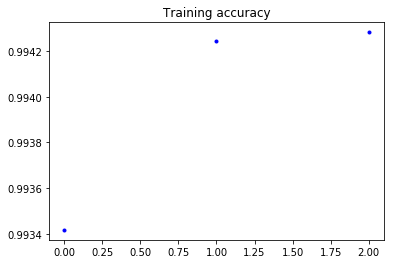

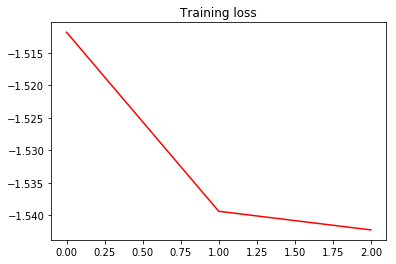

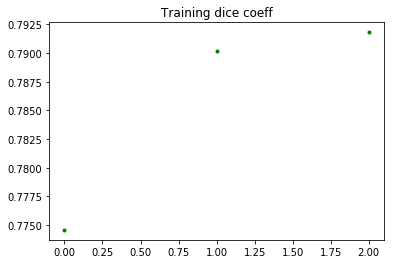

<Figure size 432x288 with 0 Axes>

In [36]:
def plot_training(history):
    acc = history.history['acc']
    print(acc)
    loss = history.history['loss']
    dice_coeff = history.history['dice_coeff']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b.')
    plt.title('Training accuracy')
    plt.figure()
    plt.plot(epochs, loss, 'r-')
    plt.title('Training loss')
    plt.figure()
    plt.plot(epochs, dice_coeff, 'g.')
    plt.title('Training dice coeff')
    plt.figure()

    plt.show()
    
plot_training(history)